<a href="https://colab.research.google.com/github/SamuelRuby/DeepLearningProjects/blob/main/Protein_structure_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install biopython py3Dmol

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 20.3 MB/s eta 0:00:00


In [3]:
# ------------------                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          # --------------------
# ---LIBRARIES------
# ------------------

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import umap
import gzip
import requests
import random
import warnings
import seaborn as sns
from tqdm import tqdm

warnings.filterwarnings('ignore')

import py3Dmol
from io import StringIO
import base64
from IPython.display import display, HTML
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.animation import FuncAnimation

from Bio import SeqIO
from Bio.PDB import PDBParser, PDBList, DSSP, PDBIO
from Bio.PDB.Structure import Structure
from Bio.PDB.Model import Model
from Bio.PDB.Chain import Chain
from Bio.PDB.Residue import Residue
from Bio.PDB.Atom import Atom


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram


# ** ASTRAL DATASET **

In [4]:
# Enhanced function to download ASTRAL data 40 with better classification parsing
def download_astral_improved(identity_cutoff=40, version="2.08"):
    """
    Download ASTRAL dataset with better classification information

    Parameters:
    -----------
    identity_cutoff : int
        Sequence identity percentage cutoff (common values: 95, 90, 70, 50, 40, 30, 25)
    version : str
        ASTRAL version (e.g., "2.08")

    Returns:
    --------
    tuple
        (sequences_file_path, domains_df, classification_df)
    """
    print(f"Downloading ASTRAL-{identity_cutoff} dataset...")

    # Create directory if it doesn't exist
    if not os.path.exists("astral_data"):
        os.makedirs("astral_data")

    # FASTA sequences with the identity cutoff
    seq_url = f"https://scop.berkeley.edu/downloads/scopeseq-{version}/astral-scopedom-seqres-gd-sel-gs-bib-{identity_cutoff}-{version}.fa"
    seq_file = f"astral_data/astral-{identity_cutoff}.fa"

    # Download sequence file if not already present
    if not os.path.exists(seq_file):
        response = requests.get(seq_url, verify=False)
        if response.status_code == 200:
            with open(seq_file, 'wb') as f:
                f.write(response.content)
            print(f"Downloaded sequences to {seq_file}")
        else:
            print(f"Failed to download from {seq_url}, status code: {response.status_code}")
            return None, None, None
    else:
        print(f"Sequence file already exists at {seq_file}")

    # Get domain classification information
    # This is the description file
    desc_url = f"https://scop.berkeley.edu/downloads/parse/dir.des.scope.{version}.txt"

    # This is the classification file (more useful for getting domain classifications)
    cla_url = f"https://scop.berkeley.edu/downloads/parse/dir.cla.scope.{version}.txt"

    try:
        # Download and parse the description file
        desc_response = requests.get(desc_url, verify=False)
        desc_data = desc_response.text

        domains_info = []
        for line in desc_data.split('\n'):
            if line.startswith('#') or not line.strip():
                continue
            fields = line.split('\t')
            if len(fields) >= 5:
                domains_info.append({
                    'sunid': fields[0],
                    'hierarchy': fields[1],
                    'sccs': fields[2],
                    'sid': fields[3],
                    'description': fields[4]
                })

        domains_df = pd.DataFrame(domains_info)
        print(f"Loaded {len(domains_df)} domain descriptions")

        # Download and parse the classification file
        cla_response = requests.get(cla_url, verify=False)
        cla_data = cla_response.text

        classification_info = []
        for line in cla_data.split('\n'):
            if line.startswith('#') or not line.strip():
                continue
            fields = line.split()
            if len(fields) >= 6:
                domain_id = fields[0]
                pdb_chain = fields[1].split(':')
                pdb_id = pdb_chain[0]
                chain = pdb_chain[1] if len(pdb_chain) > 1 else ''

                # Extract classification hierarchy
                sccs = fields[3]
                classification = fields[5].split(',')

                classification_info.append({
                    'domain_id': domain_id,
                    'pdb_id': pdb_id,
                    'chain': chain,
                    'sccs': sccs,
                    'classification': ','.join(classification),
                    'class': classification[0] if len(classification) > 0 else '',
                    'fold': classification[1] if len(classification) > 1 else '',
                    'superfamily': classification[2] if len(classification) > 2 else '',
                    'family': classification[3] if len(classification) > 3 else ''
                })

        classification_df = pd.DataFrame(classification_info)
        print(f"Loaded {len(classification_df)} domain classifications")

        return seq_file, domains_df, classification_df

    except Exception as e:
        print(f"Error processing domain information: {str(e)}")
        return seq_file, None, None

# Improved function to parse and analyze the ASTRAL dataset with classifications
def analyze_astral_dataset_improved(seq_file, classification_df):
    """
    Parse and analyze the ASTRAL dataset with proper classifications

    Parameters:
    -----------
    seq_file : str
        Path to the ASTRAL FASTA file
    classification_df : DataFrame
        DataFrame containing domain classifications

    Returns:
    --------
    tuple
        (sequences_dict, class_distribution)
    """
    if not os.path.exists(seq_file):
        print(f"Error: Sequence file {seq_file} not found")
        return None, None

    # Parse FASTA sequences
    sequences = {}
    domain_classes = {}

    for record in SeqIO.parse(seq_file, "fasta"):
        domain_id = record.id
        description = record.description

        # Extract PDB ID from domain ID
        if domain_id.startswith('d') and len(domain_id) >= 6:
            pdb_id = domain_id[1:5]
        else:
            pdb_id = "unknown"

        # Get domain class from classification dataframe
        domain_class = "unknown"
        domain_fold = "unknown"
        domain_superfamily = "unknown"

        if classification_df is not None:
            matching_rows = classification_df[classification_df['domain_id'] == domain_id]
            if not matching_rows.empty:
                domain_class = matching_rows.iloc[0]['class']
                domain_fold = matching_rows.iloc[0]['fold']
                domain_superfamily = matching_rows.iloc[0]['superfamily']

        sequences[domain_id] = {
            'sequence': str(record.seq),
            'length': len(record.seq),
            'pdb_id': pdb_id,
            'description': description,
            'class': domain_class,
            'fold': domain_fold,
            'superfamily': domain_superfamily
        }

        # Count class distribution
        if domain_class not in domain_classes:
            domain_classes[domain_class] = 0
        domain_classes[domain_class] += 1

    print(f"Loaded {len(sequences)} domain sequences")

    # Convert to DataFrame for easier analysis
    seq_df = pd.DataFrame.from_dict(sequences, orient='index')

    # Display some statistics
    print("\nSequence length statistics:")
    print(seq_df['length'].describe())

    # Plot class distribution
    plt.figure(figsize=(12, 6))
    classes = sorted(domain_classes.items(), key=lambda x: x[1], reverse=True)
    top_classes = classes[:10]  # Show top 10 classes

    labels = [c[0] if c[0] != "unknown" else "Unknown" for c in top_classes]
    values = [c[1] for c in top_classes]

    plt.bar(range(len(top_classes)), values)
    plt.xticks(range(len(top_classes)), labels, rotation=45, ha='right')
    plt.title("Top 10 Protein Domain Classes")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    return sequences, domain_classes

# Function to visualize 3D structures using py3Dmol
def visualize_domain_structure(domain_id, output_dir="astral_structures"):
    """
    Visualize the 3D structure for a specific ASTRAL domain using py3Dmol

    Parameters:
    -----------
    domain_id : str
        ASTRAL domain ID (e.g., "d1dlwa_")
    output_dir : str
        Directory where PDB files are stored
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Extract PDB ID from domain ID
    if domain_id.startswith('d') and len(domain_id) >= 6:
        pdb_id = domain_id[1:5].lower()
    else:
        print(f"Invalid domain ID format: {domain_id}")
        return

    # Check if PDB file exists, if not download it
    pdb_file = f"{output_dir}/pdb{pdb_id}.ent"
    if not os.path.exists(pdb_file):
        pdbl = PDBList()
        pdb_file = pdbl.retrieve_pdb_file(pdb_id, pdir=output_dir, file_format="pdb")
        print(f"Downloaded structure for {domain_id} (PDB ID: {pdb_id}) to {pdb_file}")
    else:
        print(f"Using existing structure file: {pdb_file}")

    # Read PDB file content
    with open(pdb_file, 'r') as f:
        pdb_data = f.read()

    # Create py3Dmol viewer
    view = py3Dmol.view(width=800, height=500)
    view.addModel(pdb_data, 'pdb')

    # Style the protein
    view.setStyle({'cartoon': {'color': 'spectrum'}})
    view.addSurface(py3Dmol.VDW, {'opacity': 0.7, 'color': 'white'})

    # Zoom to fit the structure
    view.zoomTo()

    # Display the viewer
    print(f"Displaying 3D structure for domain {domain_id} (PDB ID: {pdb_id})")
    display(view)

    return view

# Function to display classification for a specific domain
def display_domain_classification(domain_id, classification_df):
    """
    Display the full classification information for a specific domain

    Parameters:
    -----------
    domain_id : str
        ASTRAL domain ID (e.g., "d1dlwa_")
    classification_df : DataFrame
        DataFrame containing domain classifications
    """
    if classification_df is None:
        print("Classification data not available")
        return

    matching_rows = classification_df[classification_df['domain_id'] == domain_id]
    if matching_rows.empty:
        print(f"No classification found for domain {domain_id}")
        return

    domain_info = matching_rows.iloc[0]

    print(f"\nClassification for domain {domain_id}:")
    print(f"PDB ID: {domain_info['pdb_id']}")
    print(f"Chain: {domain_info['chain']}")
    print(f"SCCS: {domain_info['sccs']}")
    print(f"Class: {domain_info['class']}")
    print(f"Fold: {domain_info['fold']}")
    print(f"Superfamily: {domain_info['superfamily']}")
    print(f"Family: {domain_info['family']}")
    print(f"Full classification: {domain_info['classification']}")



Downloaded sequences to astral_data/astral-40.fa
Loaded 397955 domain descriptions
Loaded 344851 domain classifications
Loaded 15177 domain sequences

Sequence length statistics:
count    15177.000000
mean       184.819925
std        116.564364
min         20.000000
25%        102.000000
50%        151.000000
75%        246.000000
max       1664.000000
Name: length, dtype: float64


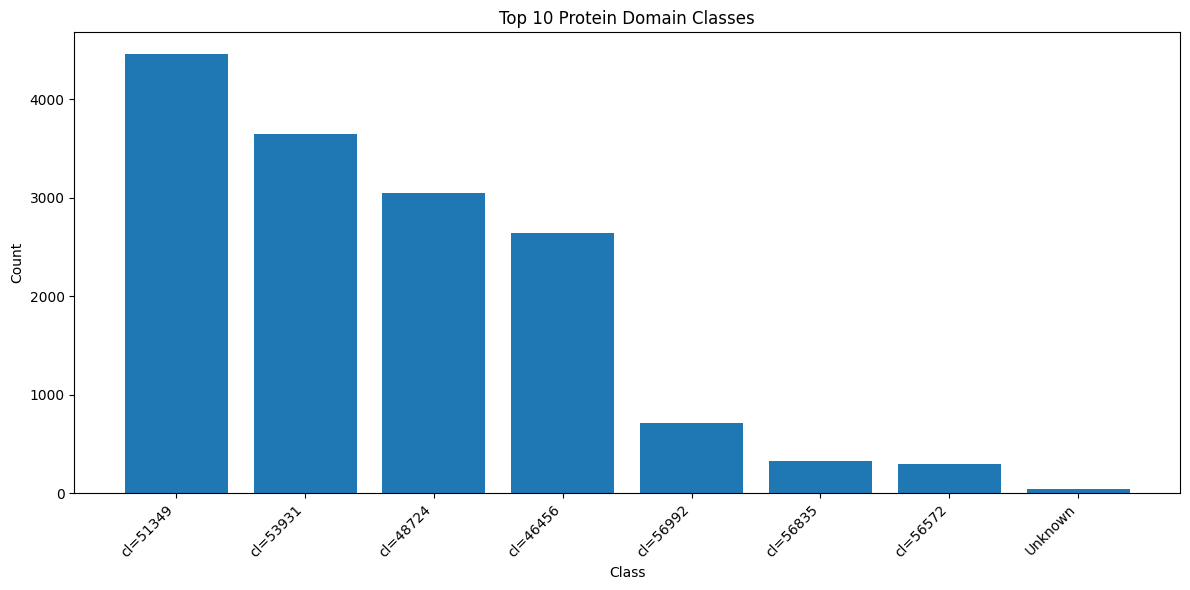


Example domain sequences with classifications:

Domain 1: d1dlwa_
PDB ID: 1dlw
Class: cl=46456
Fold: cf=46457
Superfamily: sf=46458
Length: 116 amino acids
Sequence: slfeqlggqaavqavtaqfyaniqadatvatffngidmpnqtnktaaflc...

Domain 2: d2gkma_
PDB ID: 2gkm
Class: cl=46456
Fold: cf=46457
Superfamily: sf=46458
Length: 127 amino acids
Sequence: gllsrlrkrepisiydkiggheaievvvedffvrvladdqlsaffsgtnm...

Domain 3: d1ngka_
PDB ID: 1ngk
Class: cl=46456
Fold: cf=46457
Superfamily: sf=46458
Length: 126 amino acids
Sequence: ksfydavggaktfdaivsrfyaqvaedevlrrvypeddlagaeerlrmfl...

Classification for domain d1dlwa_:
PDB ID: 1dlw
Chain: 
SCCS: a.1.1.1
Class: cl=46456
Fold: cf=46457
Superfamily: sf=46458
Family: fa=46459
Full classification: cl=46456,cf=46457,sf=46458,fa=46459,dm=46460,sp=46461,px=14982
Downloaded structure for d1dlwa_ (PDB ID: 1dlw) to astral_structures/pdb1dlw.ent
Displaying 3D structure for domain d1dlwa_ (PDB ID: 1dlw)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [5]:
#code takes 12:03 minutes
if __name__ == "__main__":
    # 1. Download ASTRAL dataset with improved classification information
    seq_file, domains_df, classification_df = download_astral_improved(identity_cutoff=40)

    if seq_file and classification_df is not None:
        # 2. Analyze the dataset with proper classifications
        sequences, class_dist = analyze_astral_dataset_improved(seq_file, classification_df)

        # 3. Show a few example sequences with their classifications
        if sequences:
            print("\nExample domain sequences with classifications:")
            for i, (domain_id, info) in enumerate(list(sequences.items())[:3]):
                print(f"\nDomain {i+1}: {domain_id}")
                print(f"PDB ID: {info['pdb_id']}")
                print(f"Class: {info['class']}")
                print(f"Fold: {info['fold']}")
                print(f"Superfamily: {info['superfamily']}")
                print(f"Length: {info['length']} amino acids")
                print(f"Sequence: {info['sequence'][:50]}...")  # Show first 50 amino acids

            # 4. Display detailed classification for the first domain
            first_domain = list(sequences.keys())[0]
            display_domain_classification(first_domain, classification_df)

            # 5. Visualize 3D structure for the first domain
            visualize_domain_structure(first_domain)

## ASTRAL-95 .


In [19]:
#code takes 23:03 minutes?
#do this instead of rewriting entire code... below for ASTRAL 95
seq_file_95, domains_df_95, classification_df_95 = download_astral_improved(identity_cutoff=95)
#seq_file_40, domains_df_40, classification_df_40 = download_astral_improved(identity_cutoff=40)

if seq_file_95 and classification_df_95 is not None:
    # 2. Analyze the dataset with proper classifications
    sequences_95, class_dist = analyze_astral_dataset_improved(seq_file_95, classification_df_95)

    # 3. Show a few example sequences with their classifications
    if sequences_95:
        print("\nExample domain sequences with classifications:")
        for i, (domain_id, info) in enumerate(list(sequences_95.items())[:3]):
            print(f"\nDomain {i+1}: {domain_id}")
            print(f"PDB ID: {info['pdb_id']}")
            print(f"Class: {info['class']}")
            print(f"Fold: {info['fold']}")
            print(f"Superfamily: {info['superfamily']}")
            print(f"Length: {info['length']} amino acids")
            print(f"Sequence: {info['sequence'][:50]}...")  # Show first 50 amino acids

        # 4. Display detailed classification for the first domain
        first_domain = list(sequences_95.keys())[0]
        display_domain_classification(first_domain, classification_df_95)

        # 5. Visualize 3D structure for the first domain
        visualize_domain_structure(first_domain)

# ** MODEL ARCHITECTURE **

## Functions ##

In [6]:
# Set random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [7]:
# 1. Data Processing Functions

def preprocess_sequences(sequences_dict, max_length=512):
    """
    Preprocess sequences dictionary into a format suitable for model training

    Parameters:
    -----------
    sequences_dict : dict
        Dictionary containing sequence information from ASTRAL
    max_length : int
        Maximum sequence length to consider

    Returns:
    --------
    tuple
        (X, y, class_names)
    """
    # Extract sequences and labels
    data = []
    labels = []

    for domain_id, info in sequences_dict.items():
        seq = info['sequence']
        label = info['class']

        # Skip sequences with unknown class
        if label == "unknown":
            continue

        data.append(seq)
        labels.append(label)

    # Encode protein sequences
    X = [encode_sequence(seq, max_length) for seq in data]
    X = np.array(X)

    # Encode labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(labels)

    return X, y, label_encoder.classes_

def encode_sequence(seq, max_length=512):
    """
    Encode amino acid sequence as numeric values

    Parameters:
    -----------
    seq : str
        Amino acid sequence
    max_length : int
        Maximum sequence length to consider

    Returns:
    --------
    numpy.ndarray
        Encoded sequence
    """
    # Amino acid to integer mapping
    aa_dict = {
        'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5,
        'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10,
        'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15,
        'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20,
        'X': 0, 'U': 0, 'O': 0, 'B': 0, 'Z': 0, 'J': 0
    }

    # Pad or truncate sequence
    if len(seq) > max_length:
        seq = seq[:max_length]
    else:
        seq = seq + 'X' * (max_length - len(seq))

    # Encode sequence
    encoded = np.array([aa_dict.get(aa, 0) for aa in seq])

    # Add channel dimension for CNN
    encoded = np.expand_dims(encoded, axis=0)

    return encoded


In [8]:
# 2. PyTorch Dataset Classes

class ProteinDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 3. Model Architecture

class ProteinCNN(nn.Module):
    def __init__(self, num_classes, input_channels=1, feature_dim=128):
        super(ProteinCNN, self).__init__()

        # Feature extraction layers
        self.features = nn.Sequential(
            nn.Conv1d(input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.AdaptiveAvgPool1d(1)
        )

        # Calculate output size of feature extraction layers
        self.feature_size = 256

        # Feature projection layer (penultimate layer)
        self.projection = nn.Linear(self.feature_size, feature_dim)

        # Classification layer
        self.classifier = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        # Feature extraction
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten

        # Feature projection (penultimate layer)
        features = self.projection(x)

        # Classification
        logits = self.classifier(features)

        return logits, features

In [9]:
# 4. Training Functions

def train_model(model, train_loader, val_loader, criterion, optimizer,
                num_epochs=10, model_save_path=None, scheduler=None):
    """
    Train the model

    Parameters:
    -----------
    model : nn.Module
        Model to train
    train_loader : DataLoader
        Training data loader
    val_loader : DataLoader
        Validation data loader
    criterion : loss function
        Loss function to optimize
    optimizer : optimizer
        Optimizer for parameter updates
    num_epochs : int
        Number of training epochs
    model_save_path : str
        Path to save best model
    scheduler : lr_scheduler
        Learning rate scheduler

    Returns:
    --------
    dict
        Training history
    """
    # Initialize history dictionary
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    # Best validation accuracy
    best_val_acc = 0.0

    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs, _ = model(inputs)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Statistics
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # Train accuracy
        train_acc = train_correct / train_total
        train_loss = train_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs, _ = model(inputs)
                loss = criterion(outputs, labels)

                # Statistics
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Validation accuracy
        val_acc = val_correct / val_total
        val_loss = val_loss / len(val_loader)

        # Update learning rate if scheduler is provided
        if scheduler is not None:
            scheduler.step(val_loss)

        # Save model if it's the best so far
        if val_acc > best_val_acc and model_save_path is not None:
            best_val_acc = val_acc
            torch.save(model.state_dict(), model_save_path)
            print(f"Saved best model with val_acc: {val_acc:.4f}")

        # Update history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        # Print statistics
        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history

def evaluate_model(model, test_loader, criterion, class_names):
    """
    Evaluate model on test set

    Parameters:
    -----------
    model : nn.Module
        Trained model
    test_loader : DataLoader
        Test data loader
    criterion : loss function
        Loss function
    class_names : list
        List of class names

    Returns:
    --------
    tuple
        (test_loss, test_acc, y_true, y_pred, features)
    """
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    all_labels = []
    all_predictions = []
    all_features = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs, features = model(inputs)
            loss = criterion(outputs, labels)

            # Statistics
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

            # Save for later analysis
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_features.extend(features.cpu().numpy())

    # Test accuracy
    test_acc = test_correct / test_total
    test_loss = test_loss / len(test_loader)

    # Print statistics
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

    # Print classification report
    report = classification_report(all_labels, all_predictions, target_names=class_names)
    print(report)

    return test_loss, test_acc, all_labels, all_predictions, np.array(all_features)

In [10]:
# 5. Visualization Functions

def plot_training_history(history):
    """
    Plot training history

    Parameters:
    -----------
    history : dict
        Training history
    """
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Plot confusion matrix

    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred : array-like
        Predicted labels
    class_names : list
        List of class names
    """
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

def visualize_features(features, labels, class_names, method='tsne'):
    """
    Visualize high-dimensional features using dimensionality reduction

    Parameters:
    -----------
    features : array-like
        Feature vectors
    labels : array-like
        Labels
    class_names : list
        List of class names
    method : str
        Dimensionality reduction method ('tsne' or 'pca')
    """
    plt.figure(figsize=(12, 10))

    # Apply dimensionality reduction
    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
        embedded = reducer.fit_transform(features)
        title = 't-SNE Visualization of Protein Features'
    else:  # PCA
        reducer = PCA(n_components=2, random_state=42)
        embedded = reducer.fit_transform(features)
        title = 'PCA Visualization of Protein Features'

    # For better visualization, limit the number of points if too many
    max_points = 5000
    if len(embedded) > max_points:
        idx = np.random.choice(len(embedded), max_points, replace=False)
        embedded = embedded[idx]
        labels = np.array(labels)[idx]

    # Plot
    unique_labels = np.unique(labels)
    for i, label in enumerate(unique_labels):
        idx = labels == label
        plt.scatter(embedded[idx, 0], embedded[idx, 1], label=class_names[label], alpha=0.6)

    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f'{method}_features.png')
    plt.show()

In [11]:
# 6. Transfer Learning Functions

def freeze_layers(model, freeze_features=True):
    """
    Freeze model layers for transfer learning

    Parameters:
    -----------
    model : nn.Module
        Model to freeze layers
    freeze_features : bool
        Whether to freeze feature extraction layers
    """
    # Freeze/unfreeze feature extraction layers
    for param in model.features.parameters():
        param.requires_grad = not freeze_features

    # Always unfreeze classification layers
    for param in model.projection.parameters():
        param.requires_grad = True
    for param in model.classifier.parameters():
        param.requires_grad = True

    return model


In [12]:
def extract_and_visualize_penultimate_features(model, dataloader, class_names, n_samples=100, device='cpu'):
    """
    Extract features from the penultimate layer of the model and visualize them

    Parameters:
    -----------
    model : nn.Module
        Trained model
    dataloader : DataLoader
        Data loader for the dataset
    class_names : list
        List of class names
    n_samples : int
        Number of samples to visualize (to avoid overcrowding)
    device : str
        Device to use for computation
    """
    model.eval()
    features_list = []
    labels_list = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass through the features and projection layers
            x = model.features(inputs)
            x = x.view(x.size(0), -1)
            features = model.projection(x)

            # Store features and labels
            features_list.append(features.cpu().numpy())
            labels_list.append(labels.cpu().numpy())

            # Limit the number of samples
            if len(features_list) * inputs.size(0) >= n_samples:
                break

    # Concatenate all features and labels
    features = np.vstack(features_list)
    labels = np.concatenate(labels_list)

    # Visualize using t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    features_tsne = tsne.fit_transform(features[:n_samples])

    # Visualize using PCA
    pca = PCA(n_components=2, random_state=42)
    features_pca = pca.fit_transform(features[:n_samples])

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Plot t-SNE
    for i, label in enumerate(np.unique(labels[:n_samples])):
        idx = labels[:n_samples] == label
        ax1.scatter(features_tsne[idx, 0], features_tsne[idx, 1], label=class_names[label], alpha=0.7)
    ax1.set_title('t-SNE Visualization of Penultimate Layer Features')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Plot PCA
    for i, label in enumerate(np.unique(labels[:n_samples])):
        idx = labels[:n_samples] == label
        ax2.scatter(features_pca[idx, 0], features_pca[idx, 1], label=class_names[label], alpha=0.7)
    ax2.set_title('PCA Visualization of Penultimate Layer Features')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.savefig('penultimate_features.png', dpi=300)
    plt.show()

    return features

def visualize_protein_structures(model, dataloader, class_names, n_proteins=5, output_dir='protein_structures', device='cpu'):
    """
    Visualize protein structures learned by the CNN by generating 3D representations
    and validating their structural features

    Parameters:
    -----------
    model : nn.Module
        Trained model
    dataloader : DataLoader
        Data loader for the dataset
    class_names : list
        List of class names
    n_proteins : int
        Number of protein structures to visualize
    output_dir : str
        Directory to save the visualizations
    device : str
        Device to use for computation
    """
    os.makedirs(output_dir, exist_ok=True)

    # Amino acid dictionary for sequence reconstruction
    aa_dict = {
        1: 'A', 2: 'C', 3: 'D', 4: 'E', 5: 'F',
        6: 'G', 7: 'H', 8: 'I', 9: 'K', 10: 'L',
        11: 'M', 12: 'N', 13: 'P', 14: 'Q', 15: 'R',
        16: 'S', 17: 'T', 18: 'V', 19: 'W', 20: 'Y',
        0: 'X'
    }

    model.eval()
    processed_proteins = 0
    validation_results = []

    # Features we'll check to validate structures
    validation_metrics = {
        'secondary_structure_ratio': [],  # Alpha helices and beta sheets
        'hydrophobic_core_score': [],     # Check if hydrophobic residues are buried
        'sequence_length': [],            # Length of the reconstructed sequence
        'class_prediction': []            # Predicted protein class
    }

    with torch.no_grad():
        for inputs, labels in dataloader:
            if processed_proteins >= n_proteins:
                break

            inputs, labels = inputs.to(device), labels.to(device)

            # Get model outputs and features
            outputs, features = model(inputs)
            predicted_classes = torch.max(outputs, 1)[1]

            for i in range(min(inputs.size(0), n_proteins - processed_proteins)):
                # Get feature map activations from different CNN layers
                layer_activations = []

                # Extract features from the convolutional layers
                # We'll use these to create a 3D representation
                x = inputs[i:i+1]

                # Forward pass through each layer individually to get activations
                for j, layer in enumerate(model.features):
                    x = layer(x)
                    if isinstance(layer, torch.nn.Conv1d):
                        layer_activations.append(x.cpu().numpy())

                # Reconstruct amino acid sequence from input
                sequence = []
                for aa_idx in inputs[i, 0].cpu().numpy():
                    aa_int = int(aa_idx)
                    if aa_int > 0:
                        sequence.append(aa_dict.get(aa_int, 'X'))
                sequence_str = ''.join(sequence)


                # Create 3D plot of feature space
                fig = plt.figure(figsize=(10, 8))
                ax = fig.add_subplot(111, projection='3d')

                # Use the last convolutional layer activations for 3D structure
                conv_features = layer_activations[-1][0]

                # Reshape for visualization (use first 3 channels for XYZ)
                n_channels = min(conv_features.shape[0], 3)
                seq_length = conv_features.shape[1]

                # Create coordinates for 3D plot
                x_coords = np.arange(seq_length)
                y_coords = np.zeros(seq_length)
                z_coords = np.zeros(seq_length)

                # Use activations to adjust y and z coordinates
                if n_channels >= 2:
                    y_coords = conv_features[1, :seq_length]
                if n_channels >= 3:
                    z_coords = conv_features[2, :seq_length]

                # Color points by amino acid properties (hydrophobicity)
                hydrophobic_aa = ['A', 'F', 'I', 'L', 'M', 'V', 'W', 'Y']
                colors = ['red' if aa in hydrophobic_aa else 'blue' for aa in sequence[:seq_length]]

                # Plot 3D structure
                ax.scatter(x_coords, y_coords, z_coords, c=colors, marker='o', s=50)

                # Connect residues with lines
                ax.plot(x_coords, y_coords, z_coords, 'k-', alpha=0.5)

                # Calculate validation metrics
                # 1. Count alpha-helices and beta-sheets based on patterns
                helix_count = 0
                sheet_count = 0

                # Simple heuristic: look for patterns in the activations
                if conv_features.shape[1] > 4:  # Make sure we have enough positions to analyze
                    for j in range(2, min(seq_length, conv_features.shape[1])-2):
                        # Check for helix pattern (regular pattern of activations)
                        if j+3 <= conv_features.shape[1] and all(abs(conv_features[0, j+k] - conv_features[0, j]) < 0.5 for k in range(1, 3)):
                            helix_count += 1
                        # Check for sheet pattern (alternating pattern)
                        elif j+2 < conv_features.shape[1] and abs(conv_features[0, j] - conv_features[0, j+2]) < 0.3:
                            sheet_count += 1

                secondary_ratio = (helix_count + sheet_count) / seq_length if seq_length > 0 else 0


                # 2. Evaluate hydrophobic core (hydrophobic residues should be buried) --> edited
                core_positions = y_coords**2 + z_coords**2 < np.mean(y_coords**2 + z_coords**2)

                # Make sure both arrays are the same length before using logical AND
                min_len = min(len(core_positions), len(sequence[:seq_length]))
                core_positions = core_positions[:min_len]
                hydrophobic_positions = np.array([aa in hydrophobic_aa for aa in sequence[:min_len]])
                # Use logical_and instead of bitwise &
                hydrophobic_core_score = np.sum(np.logical_and(core_positions, hydrophobic_positions)) / max(1, np.sum(hydrophobic_positions))

                # 3. Sequence length
                seq_len = len(sequence)

                # 4. Class prediction
                pred_class = class_names[predicted_classes[i].item()]
                true_class = class_names[labels[i].item()]

                # Add metrics to validation results
                validation_metrics['secondary_structure_ratio'].append(secondary_ratio)
                validation_metrics['hydrophobic_core_score'].append(hydrophobic_core_score)
                validation_metrics['sequence_length'].append(seq_len)
                validation_metrics['class_prediction'].append((pred_class, true_class))

                # Add title with true and predicted classes
                ax.set_title(f"Protein {processed_proteins + 1}\nTrue: {true_class}, Pred: {pred_class}")
                ax.set_xlabel('Sequence Position')
                ax.set_ylabel('Feature Dimension 1')
                ax.set_zlabel('Feature Dimension 2')

                # Save figure
                plt.tight_layout()
                plt.savefig(f"{output_dir}/protein_structure_{processed_proteins + 1}.png", dpi=300)
                plt.close()

                processed_proteins += 1

    # Plot validation metrics
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # Plot secondary structure ratio
    axs[0, 0].bar(range(len(validation_metrics['secondary_structure_ratio'])),
                validation_metrics['secondary_structure_ratio'])
    axs[0, 0].set_title('Secondary Structure Ratio')
    axs[0, 0].set_xlabel('Protein Index')
    axs[0, 0].set_ylabel('Ratio')

    # Plot hydrophobic core score
    axs[0, 1].bar(range(len(validation_metrics['hydrophobic_core_score'])),
                validation_metrics['hydrophobic_core_score'])
    axs[0, 1].set_title('Hydrophobic Core Score')
    axs[0, 1].set_xlabel('Protein Index')
    axs[0, 1].set_ylabel('Score')

    # Plot sequence length
    axs[1, 0].bar(range(len(validation_metrics['sequence_length'])),
                validation_metrics['sequence_length'])
    axs[1, 0].set_title('Sequence Length')
    axs[1, 0].set_xlabel('Protein Index')
    axs[1, 0].set_ylabel('Length')

    # Plot prediction accuracy
    correct = sum(1 for pred, true in validation_metrics['class_prediction'] if pred == true)
    accuracy = correct / len(validation_metrics['class_prediction']) if validation_metrics['class_prediction'] else 0
    axs[1, 1].bar(['Correct', 'Incorrect'], [correct, len(validation_metrics['class_prediction']) - correct])
    axs[1, 1].set_title(f'Prediction Accuracy: {accuracy:.2f}')

    plt.tight_layout()
    plt.savefig(f"{output_dir}/validation_metrics.png", dpi=300)
    plt.show()

    # Print validation summary
    print("Protein Structure Validation Summary:")
    print(f"Average Secondary Structure Ratio: {np.mean(validation_metrics['secondary_structure_ratio']):.4f}")
    print(f"Average Hydrophobic Core Score: {np.mean(validation_metrics['hydrophobic_core_score']):.4f}")
    print(f"Prediction Accuracy: {accuracy:.4f}")

    return validation_metrics

In [13]:
def integrate_visualization_functions(best_model, test_loader_40, class_names_40, device):
    print("\n=== Visualizing Penultimate Layer Features ===")
    # Extract and visualize features from the penultimate layer
    try:
        penultimate_features = extract_and_visualize_penultimate_features(
            best_model, test_loader_40, class_names_40, n_samples=200, device=device
        )

        print("\n=== Visualizing Protein Structures ===")
        # Visualize learned protein structures and validate them
        validation_metrics = visualize_protein_structures(
            best_model, test_loader_40, class_names_40, n_proteins=5,
            output_dir='protein_structures', device=device
        )

        # You can add additional analysis of the validation metrics here if needed
        return penultimate_features, validation_metrics
    except Exception as e:
        print(f"Error during visualization: {e}")
        import traceback
        traceback.print_exc()
        return None, None

## Train ##

Downloaded sequences to astral_data/astral-95.fa
Loaded 397955 domain descriptions
Loaded 344851 domain classifications
Sequence file already exists at astral_data/astral-40.fa
Loaded 397955 domain descriptions
Loaded 344851 domain classifications
Starting transfer learning pipeline...

=== Processing ASTRAL-95 dataset ===
Reading sequences from astral_data/astral-95.fa
Loaded 35494 domain sequences from ASTRAL-95

=== Processing ASTRAL-40 dataset ===
Reading sequences from astral_data/astral-40.fa
Loaded 15177 domain sequences from ASTRAL-40

=== Preprocessing Data for Training ===
ASTRAL-95: 35373 sequences, 7 classes
ASTRAL-40: 15129 sequences, 7 classes
ASTRAL-95 - Train: 28298, Val: 7075
ASTRAL-40 - Train: 9077, Val: 3026, Test: 3026

=== Pre-training on ASTRAL-95 ===


Epoch 1/15 [Val]: 100%|██████████| 222/222 [00:06<00:00, 34.61it/s]


Saved best model with val_acc: 0.2858
Epoch 1/15 - Train Loss: 1.6299, Train Acc: 0.2758, Val Loss: 2.6204, Val Acc: 0.2858


Epoch 2/15 [Val]: 100%|██████████| 222/222 [00:06<00:00, 33.82it/s]


Epoch 2/15 - Train Loss: 1.6260, Train Acc: 0.2799, Val Loss: 2.7723, Val Acc: 0.2637


Epoch 3/15 [Val]: 100%|██████████| 222/222 [00:06<00:00, 34.77it/s]


Epoch 3/15 - Train Loss: 1.6244, Train Acc: 0.2813, Val Loss: 2.1905, Val Acc: 0.2858


Epoch 4/15 [Val]: 100%|██████████| 222/222 [00:05<00:00, 38.05it/s]


Epoch 4/15 - Train Loss: 1.6239, Train Acc: 0.2823, Val Loss: 6.1162, Val Acc: 0.2858


Epoch 5/15 [Val]: 100%|██████████| 222/222 [00:05<00:00, 40.73it/s]


Epoch 5/15 - Train Loss: 1.6238, Train Acc: 0.2831, Val Loss: 3.0250, Val Acc: 0.2858


Epoch 6/15 [Val]: 100%|██████████| 222/222 [00:05<00:00, 40.67it/s]


Epoch 6/15 - Train Loss: 1.6237, Train Acc: 0.2860, Val Loss: 3.9893, Val Acc: 0.2858


Epoch 7/15 [Val]: 100%|██████████| 222/222 [00:05<00:00, 39.98it/s]


Epoch 7/15 - Train Loss: 1.6235, Train Acc: 0.2854, Val Loss: 11.6091, Val Acc: 0.2637


Epoch 8/15 [Val]: 100%|██████████| 222/222 [00:05<00:00, 40.70it/s]


Epoch 8/15 - Train Loss: 1.6225, Train Acc: 0.2845, Val Loss: 12.6524, Val Acc: 0.2637


Epoch 9/15 [Val]: 100%|██████████| 222/222 [00:05<00:00, 40.15it/s]


Epoch 9/15 - Train Loss: 1.6222, Train Acc: 0.2821, Val Loss: 12.3575, Val Acc: 0.2858


Epoch 10/15 [Val]: 100%|██████████| 222/222 [00:05<00:00, 37.48it/s]


Epoch 10/15 - Train Loss: 1.6223, Train Acc: 0.2833, Val Loss: 23.5890, Val Acc: 0.2858


Epoch 11/15 [Val]: 100%|██████████| 222/222 [00:06<00:00, 33.09it/s]


Epoch 11/15 - Train Loss: 1.6225, Train Acc: 0.2829, Val Loss: 110.8961, Val Acc: 0.2858


Epoch 12/15 [Val]: 100%|██████████| 222/222 [00:06<00:00, 32.73it/s]


Epoch 12/15 - Train Loss: 1.6218, Train Acc: 0.2854, Val Loss: 10.6629, Val Acc: 0.2858


Epoch 13/15 [Val]: 100%|██████████| 222/222 [00:06<00:00, 32.65it/s]


Epoch 13/15 - Train Loss: 1.6218, Train Acc: 0.2847, Val Loss: 17.6238, Val Acc: 0.2858


Epoch 14/15 [Val]: 100%|██████████| 222/222 [00:06<00:00, 33.84it/s]


Epoch 14/15 - Train Loss: 1.6219, Train Acc: 0.2859, Val Loss: 65.7428, Val Acc: 0.2858


Epoch 15/15 [Val]: 100%|██████████| 222/222 [00:05<00:00, 38.96it/s]


Epoch 15/15 - Train Loss: 1.6223, Train Acc: 0.2846, Val Loss: 102.0145, Val Acc: 0.2858


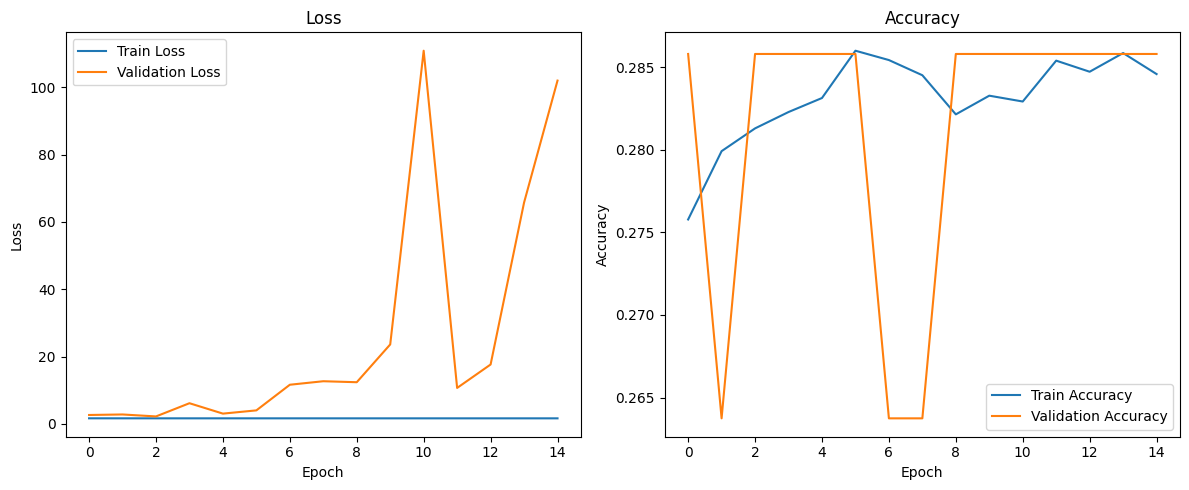


=== Fine-tuning on ASTRAL-40 ===


Epoch 1/10 [Val]: 100%|██████████| 95/95 [00:03<00:00, 30.03it/s]


Saved best model with val_acc: 0.2406
Epoch 1/10 - Train Loss: 1.6473, Train Acc: 0.2861, Val Loss: 1.6454, Val Acc: 0.2406


Epoch 2/10 [Val]: 100%|██████████| 95/95 [00:02<00:00, 37.67it/s]


Saved best model with val_acc: 0.2944
Epoch 2/10 - Train Loss: 1.6436, Train Acc: 0.2935, Val Loss: 1.6400, Val Acc: 0.2944


Epoch 3/10 [Val]: 100%|██████████| 95/95 [00:02<00:00, 37.98it/s]


Epoch 3/10 - Train Loss: 1.6434, Train Acc: 0.2828, Val Loss: 1.6379, Val Acc: 0.2944


Epoch 4/10 [Val]: 100%|██████████| 95/95 [00:02<00:00, 37.76it/s]


Epoch 4/10 - Train Loss: 1.6402, Train Acc: 0.2928, Val Loss: 1.6379, Val Acc: 0.2944


Epoch 5/10 [Val]: 100%|██████████| 95/95 [00:02<00:00, 37.42it/s]


Epoch 5/10 - Train Loss: 1.6413, Train Acc: 0.2918, Val Loss: 1.6447, Val Acc: 0.2944


Epoch 6/10 [Val]: 100%|██████████| 95/95 [00:02<00:00, 36.66it/s]


Epoch 6/10 - Train Loss: 1.6399, Train Acc: 0.2944, Val Loss: 1.6427, Val Acc: 0.2944


Epoch 7/10 [Val]: 100%|██████████| 95/95 [00:02<00:00, 37.39it/s]


Epoch 7/10 - Train Loss: 1.6408, Train Acc: 0.2918, Val Loss: 1.6410, Val Acc: 0.2406


Epoch 8/10 [Val]: 100%|██████████| 95/95 [00:02<00:00, 37.84it/s]


Epoch 8/10 - Train Loss: 1.6385, Train Acc: 0.2933, Val Loss: 1.6377, Val Acc: 0.2944


Epoch 9/10 [Val]: 100%|██████████| 95/95 [00:02<00:00, 34.29it/s]


Epoch 9/10 - Train Loss: 1.6386, Train Acc: 0.2944, Val Loss: 1.6389, Val Acc: 0.2944


Epoch 10/10 [Val]: 100%|██████████| 95/95 [00:03<00:00, 31.41it/s]


Epoch 10/10 - Train Loss: 1.6389, Train Acc: 0.2944, Val Loss: 1.6367, Val Acc: 0.2944


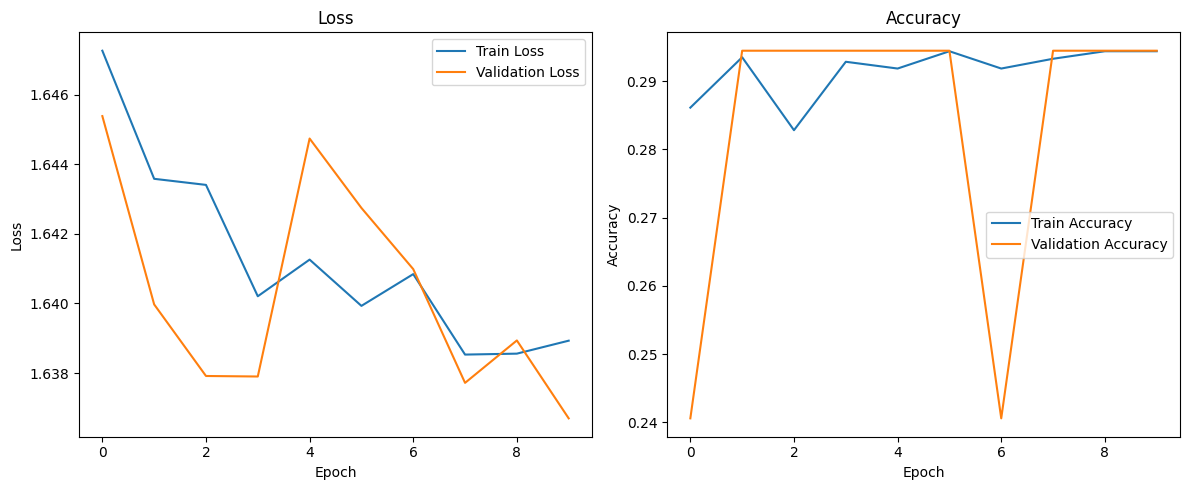


=== Evaluating Fine-tuned Model ===


Evaluating: 100%|██████████| 95/95 [00:02<00:00, 37.53it/s]


Test Loss: 1.6393, Test Acc: 0.2944
              precision    recall  f1-score   support

    cl=46456       0.00      0.00      0.00       528
    cl=48724       0.00      0.00      0.00       609
    cl=51349       0.29      1.00      0.45       891
    cl=53931       0.00      0.00      0.00       729
    cl=56572       0.00      0.00      0.00        60
    cl=56835       0.00      0.00      0.00        66
    cl=56992       0.00      0.00      0.00       143

    accuracy                           0.29      3026
   macro avg       0.04      0.14      0.06      3026
weighted avg       0.09      0.29      0.13      3026


=== Generating Visualizations ===


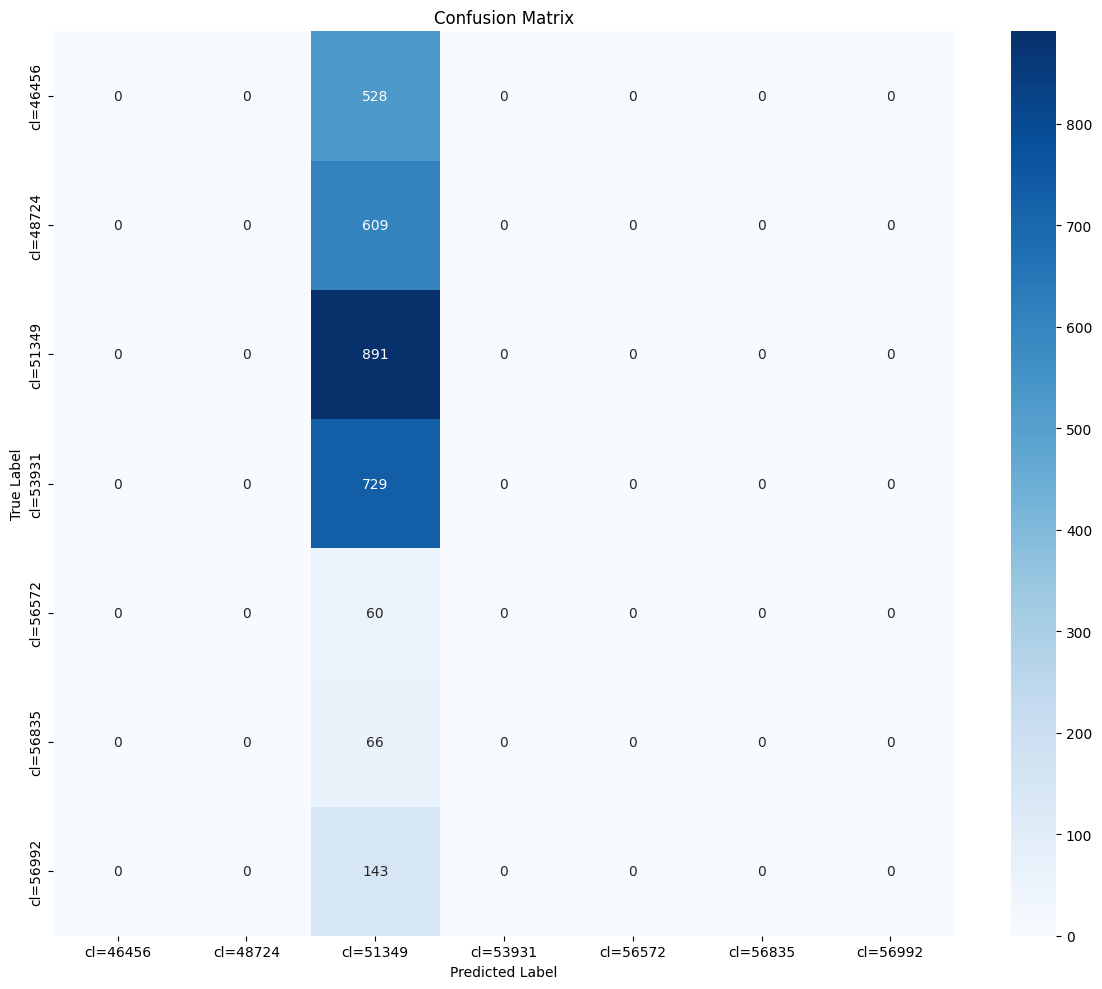

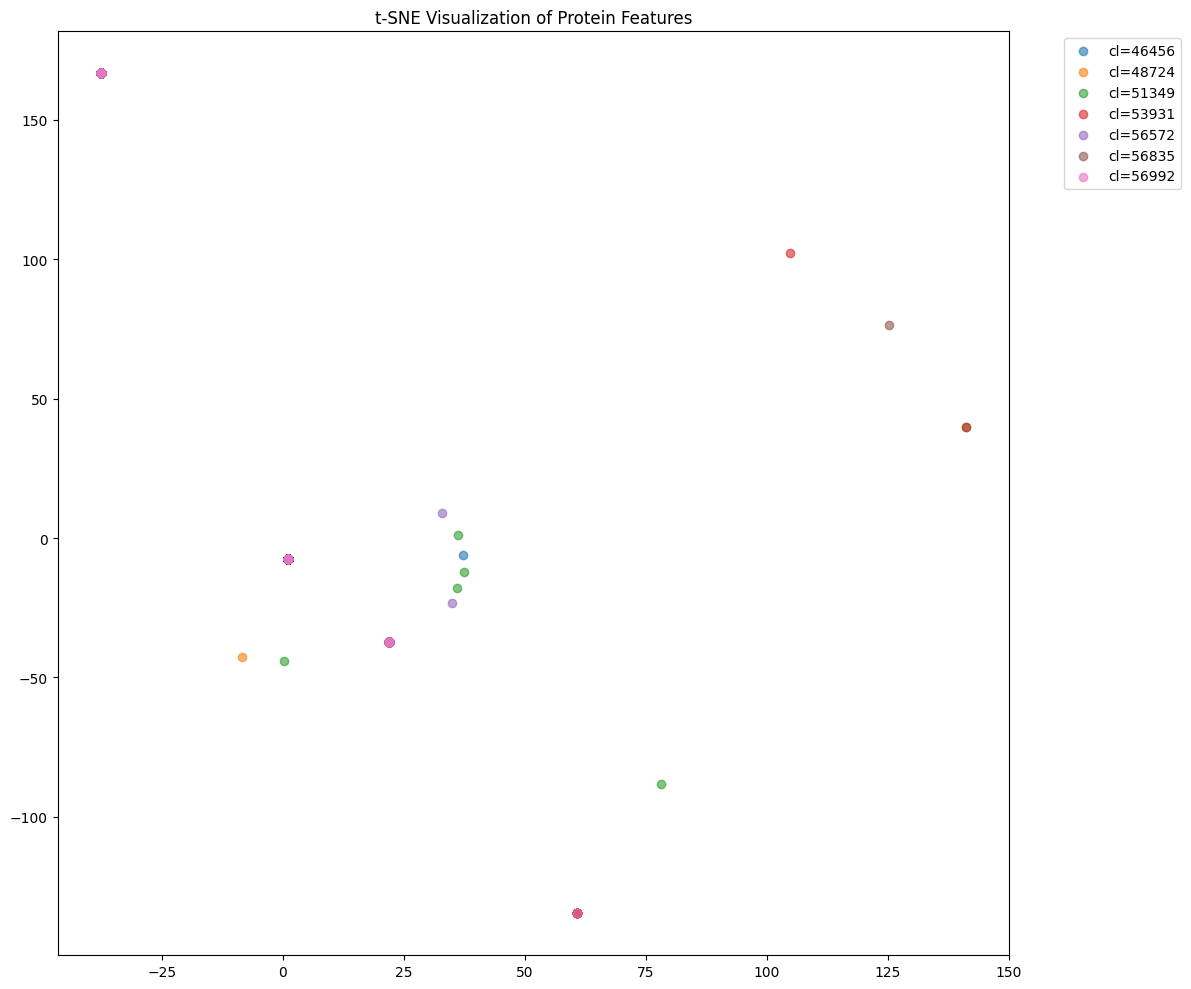

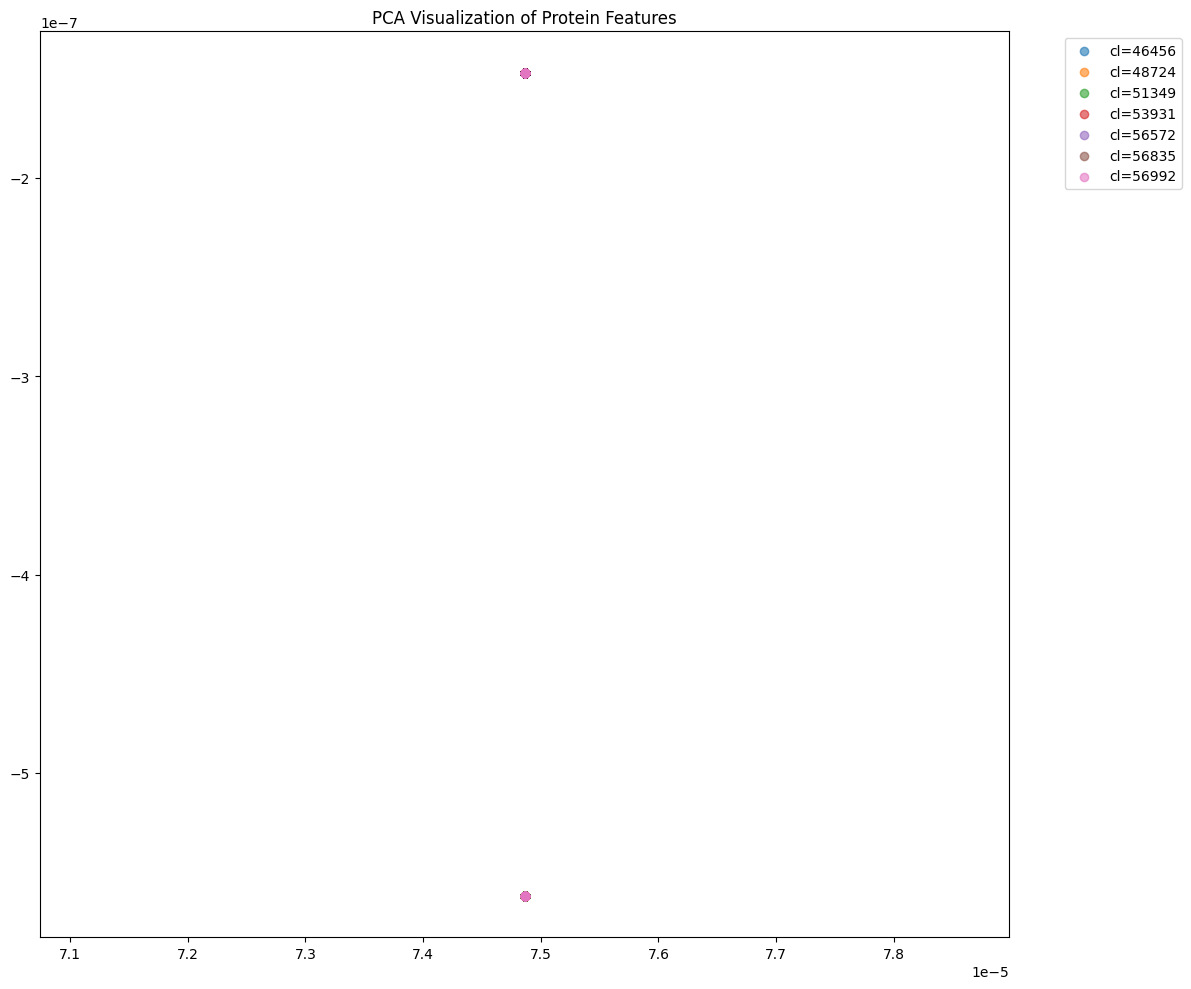

Transfer learning pipeline completed!

=== Visualizing Penultimate Layer Features ===


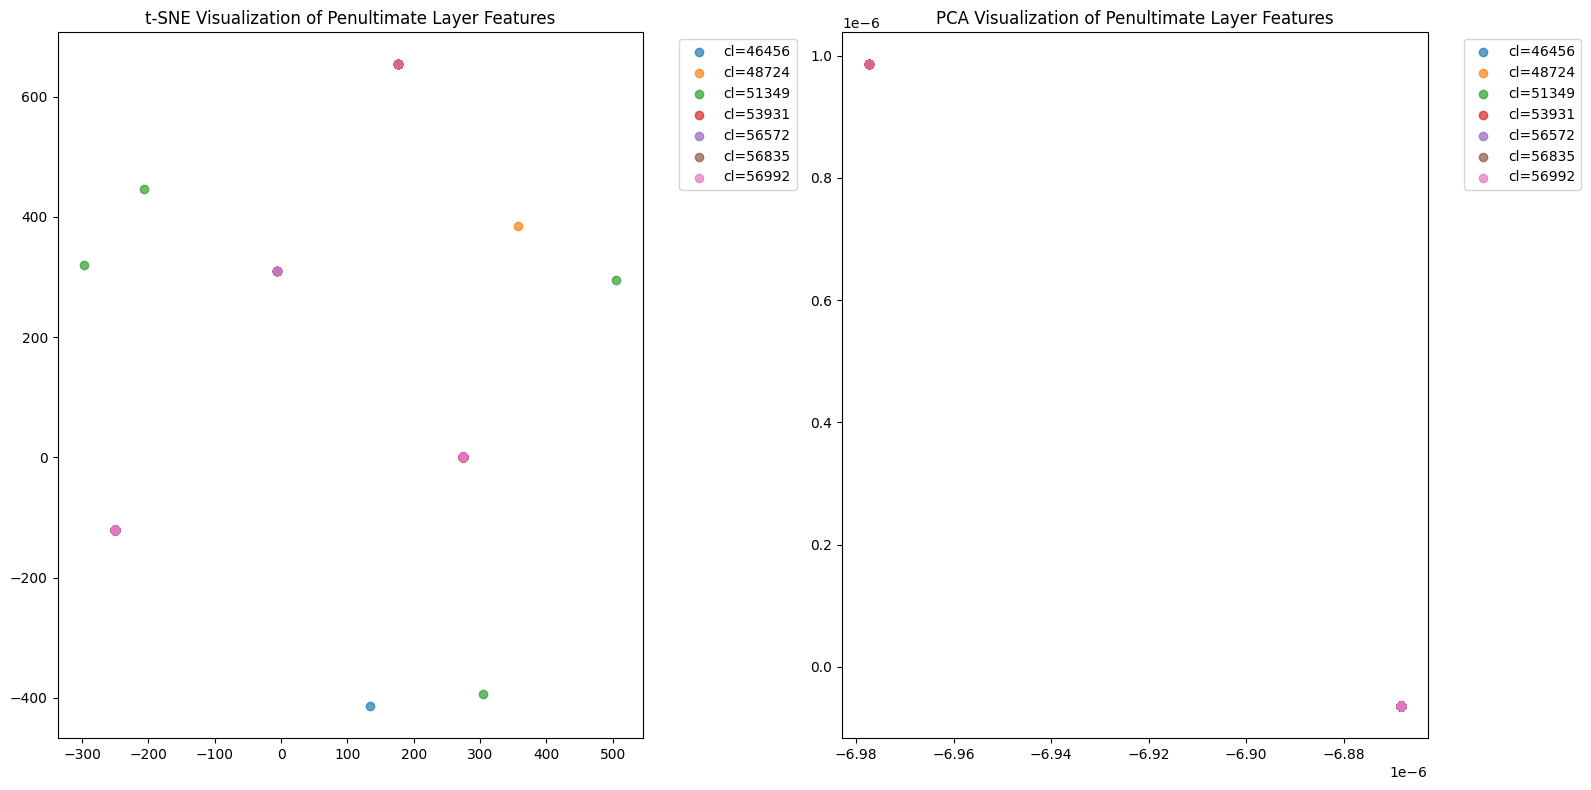


=== Visualizing Protein Structures ===


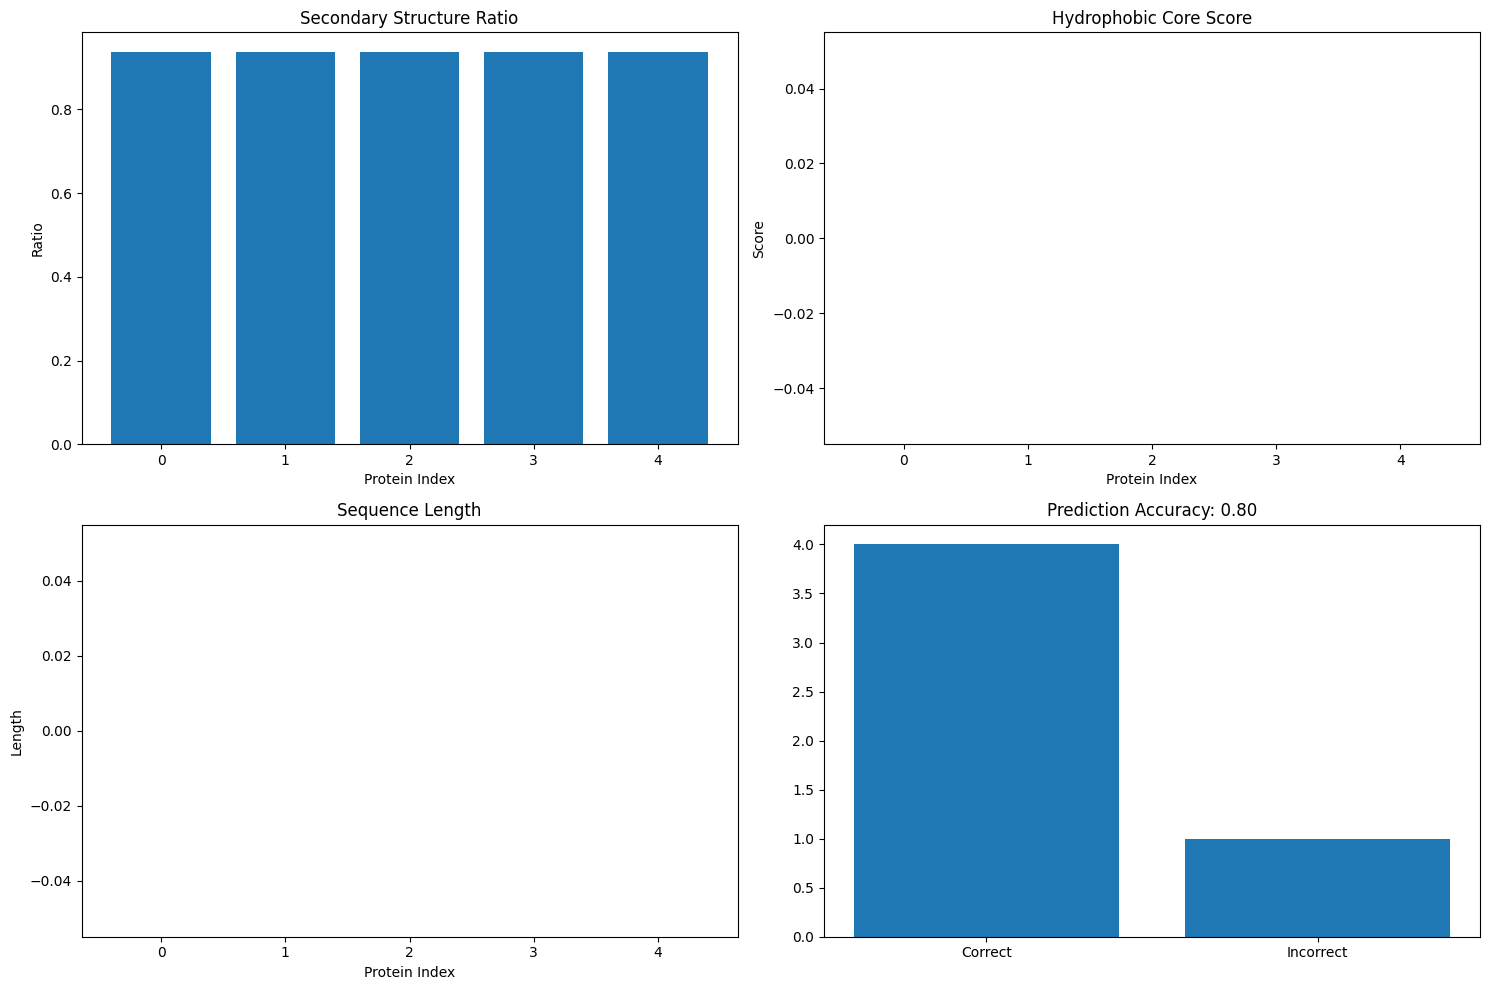

Protein Structure Validation Summary:
Average Secondary Structure Ratio: 0.9375
Average Hydrophobic Core Score: 0.0000
Prediction Accuracy: 0.8000
Transfer learning pipeline completed with additional visualizations!


In [14]:

# 7. Main Function for Transfer Learning Pipeline

def transfer_learning_pipeline(seq_file_95, seq_file_40, classification_df_95, classification_df_40):
    """
    Complete transfer learning pipeline using ASTRAL datasets

    Parameters:
    -----------
    seq_file_95 : str
        Path to ASTRAL-95 sequences file
    seq_file_40 : str
        Path to ASTRAL-40 sequences file
    classification_df_95 : DataFrame
        ASTRAL-95 classification data
    classification_df_40 : DataFrame
        ASTRAL-40 classification data
    """
    print("Starting transfer learning pipeline...")

    # 1. Process ASTRAL-95 for pre-training
    print("\n=== Processing ASTRAL-95 dataset ===")
    sequences_95 = {}
    domain_classes_95 = {}

    print(f"Reading sequences from {seq_file_95}")
    for record in SeqIO.parse(seq_file_95, "fasta"):
        domain_id = record.id
        description = record.description

        # Extract PDB ID from domain ID
        if domain_id.startswith('d') and len(domain_id) >= 6:
            pdb_id = domain_id[1:5]
        else:
            pdb_id = "unknown"

        # Get domain class from classification dataframe
        domain_class = "unknown"
        domain_fold = "unknown"
        domain_superfamily = "unknown"

        if classification_df_95 is not None:
            matching_rows = classification_df_95[classification_df_95['domain_id'] == domain_id]
            if not matching_rows.empty:
                domain_class = matching_rows.iloc[0]['class']
                domain_fold = matching_rows.iloc[0]['fold']
                domain_superfamily = matching_rows.iloc[0]['superfamily']

        sequences_95[domain_id] = {
            'sequence': str(record.seq),
            'length': len(record.seq),
            'pdb_id': pdb_id,
            'description': description,
            'class': domain_class,
            'fold': domain_fold,
            'superfamily': domain_superfamily
        }

        # Count class distribution
        if domain_class not in domain_classes_95:
            domain_classes_95[domain_class] = 0
        domain_classes_95[domain_class] += 1

    print(f"Loaded {len(sequences_95)} domain sequences from ASTRAL-95")

    # 2. Process ASTRAL-40 for fine-tuning
    print("\n=== Processing ASTRAL-40 dataset ===")
    sequences_40 = {}
    domain_classes_40 = {}

    print(f"Reading sequences from {seq_file_40}")
    for record in SeqIO.parse(seq_file_40, "fasta"):
        domain_id = record.id
        description = record.description

        # Extract PDB ID from domain ID
        if domain_id.startswith('d') and len(domain_id) >= 6:
            pdb_id = domain_id[1:5]
        else:
            pdb_id = "unknown"

        # Get domain class from classification dataframe
        domain_class = "unknown"
        domain_fold = "unknown"
        domain_superfamily = "unknown"

        if classification_df_40 is not None:
            matching_rows = classification_df_40[classification_df_40['domain_id'] == domain_id]
            if not matching_rows.empty:
                domain_class = matching_rows.iloc[0]['class']
                domain_fold = matching_rows.iloc[0]['fold']
                domain_superfamily = matching_rows.iloc[0]['superfamily']

        sequences_40[domain_id] = {
            'sequence': str(record.seq),
            'length': len(record.seq),
            'pdb_id': pdb_id,
            'description': description,
            'class': domain_class,
            'fold': domain_fold,
            'superfamily': domain_superfamily
        }

        # Count class distribution
        if domain_class not in domain_classes_40:
            domain_classes_40[domain_class] = 0
        domain_classes_40[domain_class] += 1

    print(f"Loaded {len(sequences_40)} domain sequences from ASTRAL-40")

    # 3. Preprocess data for training
    print("\n=== Preprocessing Data for Training ===")
    max_length = 512  # Maximum sequence length to consider

    # Preprocess ASTRAL-95 data
    X_95, y_95, class_names_95 = preprocess_sequences(sequences_95, max_length)
    print(f"ASTRAL-95: {X_95.shape[0]} sequences, {len(class_names_95)} classes")

    # Preprocess ASTRAL-40 data
    X_40, y_40, class_names_40 = preprocess_sequences(sequences_40, max_length)
    print(f"ASTRAL-40: {X_40.shape[0]} sequences, {len(class_names_40)} classes")

    # 4. Split data into training and validation sets
    # ASTRAL-95 split for pre-training
    X_train_95, X_val_95, y_train_95, y_val_95 = train_test_split(
        X_95, y_95, test_size=0.2, random_state=42, stratify=y_95
    )

    # ASTRAL-40 split for fine-tuning
    X_train_40, X_test_40, y_train_40, y_test_40 = train_test_split(
        X_40, y_40, test_size=0.2, random_state=42, stratify=y_40
    )
    X_train_40, X_val_40, y_train_40, y_val_40 = train_test_split(
        X_train_40, y_train_40, test_size=0.25, random_state=42, stratify=y_train_40
    )

    print(f"ASTRAL-95 - Train: {X_train_95.shape[0]}, Val: {X_val_95.shape[0]}")
    print(f"ASTRAL-40 - Train: {X_train_40.shape[0]}, Val: {X_val_40.shape[0]}, Test: {X_test_40.shape[0]}")

    # 5. Create PyTorch datasets and dataloaders
    # For ASTRAL-95 pre-training
    train_dataset_95 = ProteinDataset(X_train_95, y_train_95)
    val_dataset_95 = ProteinDataset(X_val_95, y_val_95)

    train_loader_95 = DataLoader(train_dataset_95, batch_size=32, shuffle=True, num_workers=2)
    val_loader_95 = DataLoader(val_dataset_95, batch_size=32, shuffle=False, num_workers=2)

    # For ASTRAL-40 fine-tuning
    train_dataset_40 = ProteinDataset(X_train_40, y_train_40)
    val_dataset_40 = ProteinDataset(X_val_40, y_val_40)
    test_dataset_40 = ProteinDataset(X_test_40, y_test_40)

    train_loader_40 = DataLoader(train_dataset_40, batch_size=32, shuffle=True, num_workers=2)
    val_loader_40 = DataLoader(val_dataset_40, batch_size=32, shuffle=False, num_workers=2)
    test_loader_40 = DataLoader(test_dataset_40, batch_size=32, shuffle=False, num_workers=2)

    # 6. Create model directory if it doesn't exist
    os.makedirs("models", exist_ok=True)

    # 7. Pre-train on ASTRAL-95
    print("\n=== Pre-training on ASTRAL-95 ===")

    # Create model
    model = ProteinCNN(num_classes=len(class_names_95), input_channels=1).to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    # Train model
    pretrain_history = train_model(
        model, train_loader_95, val_loader_95, criterion, optimizer,
        num_epochs=15, model_save_path="models/pretrained_model.pth", scheduler=scheduler
    )

    # Plot training history
    plot_training_history(pretrain_history)

    # 8. Fine-tune on ASTRAL-40
    print("\n=== Fine-tuning on ASTRAL-40 ===")

    # Load pre-trained model
    pretrained_model = ProteinCNN(num_classes=len(class_names_95), input_channels=1).to(device)
    pretrained_model.load_state_dict(torch.load("models/pretrained_model.pth"))

    # Create new model for fine-tuning with new classification layer
    model_ft = ProteinCNN(num_classes=len(class_names_40), input_channels=1).to(device)

    # Copy weights from pre-trained model for all layers except the classifier
    model_ft_dict = model_ft.state_dict()
    pretrained_dict = {k: v for k, v in pretrained_model.state_dict().items() if 'classifier' not in k}
    model_ft_dict.update(pretrained_dict)
    model_ft.load_state_dict(model_ft_dict)

    # Freeze feature extraction layers
    model_ft = freeze_layers(model_ft, freeze_features=True)

    # Define loss function and optimizer for fine-tuning
    criterion_ft = nn.CrossEntropyLoss()
    optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=0.0005)
    scheduler_ft = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='min', factor=0.5, patience=3)

    # Fine-tune model
    finetune_history = train_model(
        model_ft, train_loader_40, val_loader_40, criterion_ft, optimizer_ft,
        num_epochs=10, model_save_path="models/finetuned_model.pth", scheduler=scheduler_ft
    )

    # Plot fine-tuning history
    plot_training_history(finetune_history)

    # 9. Evaluate fine-tuned model on test set
    print("\n=== Evaluating Fine-tuned Model ===")

    # Load best fine-tuned model
    best_model = ProteinCNN(num_classes=len(class_names_40), input_channels=1).to(device)
    best_model.load_state_dict(torch.load("models/finetuned_model.pth"))

    # Evaluate model
    test_loss, test_acc, y_true, y_pred, features = evaluate_model(
        best_model, test_loader_40, criterion_ft, class_names_40
    )

    # 10. Visualize results
    print("\n=== Generating Visualizations ===")

    # Plot confusion matrix
    plot_confusion_matrix(y_true, y_pred, class_names_40)

    # Visualize features using t-SNE
    visualize_features(features, y_true, class_names_40, method='tsne')

    # Visualize features using PCA
    visualize_features(features, y_true, class_names_40, method='pca')

    print("Transfer learning pipeline completed!")


    # 11. Visualize penultimate layer features and protein structures
    penultimate_features, validation_metrics = integrate_visualization_functions(
        best_model, test_loader_40, class_names_40, device
    )
    print("Transfer learning pipeline completed with additional visualizations!")

# 8. Main Code Execution

if __name__ == "__main__":
    # This function is called after loading the datasets using download_astral_improved

    # Example usage:
    # 1. First download both datasets
    seq_file_95, domains_df_95, classification_df_95 = download_astral_improved(identity_cutoff=95)
    seq_file_40, domains_df_40, classification_df_40 = download_astral_improved(identity_cutoff=40)

    # 2. Run transfer learning pipeline
    if seq_file_95 and seq_file_40 and classification_df_95 is not None and classification_df_40 is not None:
        transfer_learning_pipeline(
            seq_file_95, seq_file_40, classification_df_95, classification_df_40
        )
    else:
        print("Error: Failed to load one or more datasets. Please check the download function output.")

## SCOPE DATASET ##

In [ ]:
#######################################################
# SCOP/SCOPe Database Access - Hierarchical classification system with classes, folds, superfamilies and families
#######################################################

def download_scope_data(version="2.08"):
    """
    Download and parse SCOP/SCOPe classification data

    Parameters:
    -----------
    version : str
        SCOPe version (e.g., "2.08")

    Returns:
    --------
    dict
        Dictionary of DataFrames containing different aspects of SCOP/SCOPe data
    """
    print(f"Downloading SCOPe v{version} data...")

    base_url = f"https://scop.berkeley.edu/downloads/parse"


    #https://scop.berkeley.edu/downloads/parse/dir.hie.scope.2.08-stable.txt


    # Create directory for data
    if not os.path.exists("scope_data"):
        os.makedirs("scope_data")

    # Files to download and their descriptions
    scope_files = {
        "dir.cla.scope.txt": "Classification of domains",
        "dir.des.scope.txt": "Descriptions of SCOP nodes",
        "dir.hie.scope.txt": "Hierarchy information",
        "dir.com.scope.txt": "Comments",
    }

    scope_data = {}

    for file_name, description in scope_files.items():
        name_parts = file_name.rsplit('.txt', 1) # Split from the right, only once
        if len(name_parts) == 2:
            base_name = name_parts[0]
            extension = name_parts[1] #will be an empty string if ended in txt
            url = f"{base_url}/{base_name}.{version}.txt"
        else:
            print(f"Warning: Filename '{file_name}' does not end with '.txt'. Using default URL format.")
            url = f"{base_url}/{file_name}.{version}" # Fallback to original format

        file_path = f"scope_data/{file_name}.{version}"

        # Download file if not already present
        if not os.path.exists(file_path):
            try:
                response = requests.get(url, verify=False)
                if response.status_code == 200:
                    with open(file_path, 'wb') as f:
                        f.write(response.content)
                    print(f"Downloaded {description} to {file_path}")
                else:
                    print(f"Failed to download {file_name}, status code: {response.status_code}")
                    continue
            except Exception as e:
                print(f"Error downloading {file_name}: {str(e)}")
                continue
        else:
            print(f"{file_name} already exists at {file_path}")

        # Parse file based on its format
        if "cla" in file_name:  # Classification file
            try:
                data = []
                with open(file_path, 'r') as f:
                    for line in f:
                        if line.startswith('#') or not line.strip():
                            continue
                        fields = line.split()
                        if len(fields) >= 6:
                            domain_id = fields[0]
                            pdb_chain = fields[1].split(':')
                            pdb_id = pdb_chain[0]
                            chain = pdb_chain[1] if len(pdb_chain) > 1 else ''

                            # Extract classification hierarchy
                            sccs = fields[3]
                            classification = fields[5].split(',')

                            data.append({
                                'domain_id': domain_id,
                                'pdb_id': pdb_id,
                                'chain': chain,
                                'sccs': sccs,
                                'classification': ','.join(classification),
                                'class': classification[0] if len(classification) > 0 else '',
                                'fold': classification[1] if len(classification) > 1 else '',
                                'superfamily': classification[2] if len(classification) > 2 else '',
                                'family': classification[3] if len(classification) > 3 else ''
                            })

                scope_data['classification'] = pd.DataFrame(data)
                print(f"Loaded {len(data)} domain classifications")
            except Exception as e:
                print(f"Error parsing classification data: {str(e)}")

        elif "des" in file_name:  # Description file
            try:
                data = []
                with open(file_path, 'r') as f:
                    for line in f:
                        if line.startswith('#') or not line.strip():
                            continue
                        fields = line.split('\t')
                        if len(fields) >= 5:
                            data.append({
                                'sunid': fields[0],
                                'hierarchy': fields[1],
                                'sccs': fields[2],
                                'sid': fields[3],
                                'description': fields[4].strip()
                            })

                scope_data['descriptions'] = pd.DataFrame(data)
                print(f"Loaded {len(data)} SCOP node descriptions")
            except Exception as e:
                print(f"Error parsing description data: {str(e)}")

        elif "hie" in file_name:  # Hierarchy file
            try:
                data = []
                with open(file_path, 'r') as f:
                    for line in f:
                        if line.startswith('#') or not line.strip():
                            continue
                        fields = line.split('\t')
                        if len(fields) >= 3:
                            data.append({
                                'sunid': fields[0],
                                'parent': fields[1],
                                'children': fields[2].strip()
                            })

                scope_data['hierarchy'] = pd.DataFrame(data)
                print(f"Loaded {len(data)} hierarchy relationships")
            except Exception as e:
                print(f"Error parsing hierarchy data: {str(e)}")

        elif "com" in file_name:  # Comments file
            try:
                data = []
                with open(file_path, 'r') as f:
                    for line in f:
                        if line.startswith('#') or not line.strip():
                            continue
                        fields = line.split('\t')
                        if len(fields) >= 2:
                            data.append({
                                'sunid': fields[0],
                                'comment': fields[1].strip()
                            })

                scope_data['comments'] = pd.DataFrame(data)
                print(f"Loaded {len(data)} comments")
            except Exception as e:
                print(f"Error parsing comments data: {str(e)}")

    return scope_data

def analyze_scope_data(scope_data):
    """
    Analyze and visualize SCOP/SCOPe data

    Parameters:
    -----------
    scope_data : dict
        Dictionary of DataFrames from download_scope_data()
    """
    if 'classification' not in scope_data:
        print("Classification data not available")
        return

    classification_df = scope_data['classification']

    # 1. Analyze class distribution
    print("\nSCOP Class Distribution:")
    class_counts = classification_df['class'].value_counts()
    print(class_counts)

    plt.figure(figsize=(10, 6))
    class_counts.plot(kind='bar')
    plt.title('SCOP Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 2. Show SCOP hierarchy example
    print("\nSCOP Hierarchy Example:")
    if len(classification_df) > 0:
        example = classification_df.iloc[0]
        print(f"Domain: {example['domain_id']}")
        print(f"PDB ID: {example['pdb_id']}")
        print(f"Chain: {example['chain']}")
        print(f"SCCS: {example['sccs']}")
        print(f"Class: {example['class']}")
        print(f"Fold: {example['fold']}")
        print(f"Superfamily: {example['superfamily']}")
        print(f"Family: {example['family']}")

    # 3. Show example descriptions
    if 'descriptions' in scope_data:
        print("\nSCOP Description Examples:")
        for i, desc in scope_data['descriptions'].head(5).iterrows():
            print(f"ID: {desc['sid']}, Type: {desc['hierarchy']}, Desc: {desc['description']}")


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'scop.berkeley.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded Classification of domains to scope_data/dir.cla.scope.txt.2.08
Loaded 344851 domain classifications


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'scop.berkeley.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded Descriptions of SCOP nodes to scope_data/dir.des.scope.txt.2.08
Loaded 397955 SCOP node descriptions


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'scop.berkeley.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded Hierarchy information to scope_data/dir.hie.scope.txt.2.08
Loaded 343469 hierarchy relationships


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'scop.berkeley.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded Comments to scope_data/dir.com.scope.txt.2.08
Loaded 0 comments

SCOP Class Distribution:
class
cl=51349     84010
cl=48724     76704
cl=53931     76035
cl=46456     44351
cl=310555    35367
cl=56572      7353
cl=56992      7138
cl=56835      7018
cl=58117      2866
cl=57942      2715
cl=58231       978
cl=58788       316
Name: count, dtype: int64


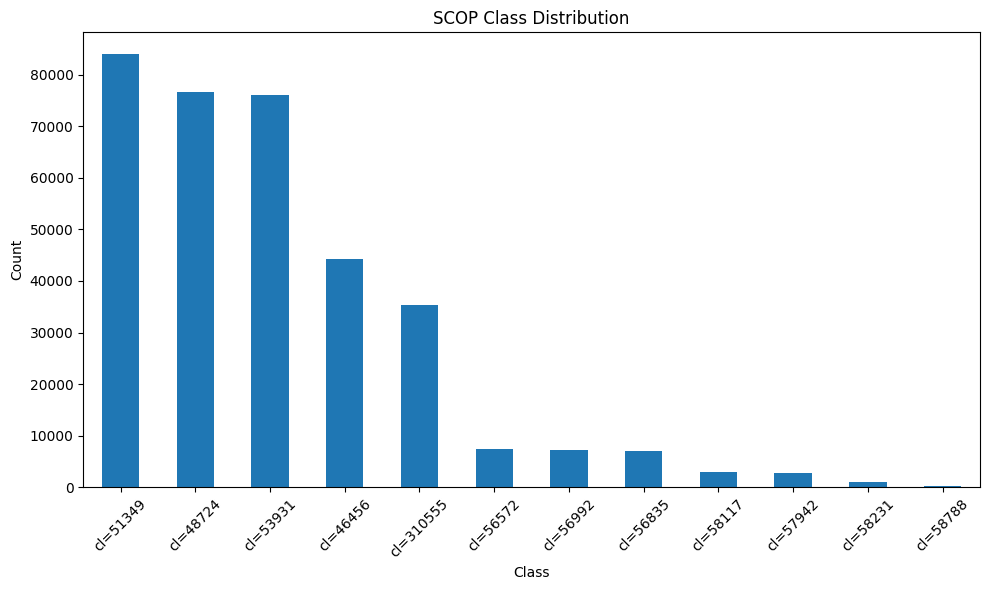


SCOP Hierarchy Example:
Domain: d1ux8a_
PDB ID: 1ux8
Chain: 
SCCS: a.1.1.1
Class: cl=46456
Fold: cf=46457
Superfamily: sf=46458
Family: fa=46459

SCOP Description Examples:
ID: -, Type: cl, Desc: All alpha proteins
ID: -, Type: cf, Desc: Globin-like
ID: -, Type: sf, Desc: Globin-like
ID: -, Type: fa, Desc: Truncated hemoglobin
ID: -, Type: dm, Desc: Protozoan/bacterial hemoglobin


In [ ]:
if __name__ == "__main__":
    # 1. Download and analyze SCOP/SCOPe data
    scope_data = download_scope_data()
    if scope_data:
        analyze_scope_data(scope_data)

## ECOD ##

In [ ]:

#######################################################
# ECOD Database Access - ECOD (Evolutionary Classification of Protein Domains)
# Modern database with evolutionary relationships emphasized
#######################################################

def download_ecod_data(version="develop277"):
    """
    Download and parse ECOD (Evolutionary Classification of Protein Domains) data

    Parameters:
    -----------
    version : str
        ECOD version (e.g., "develop277")

    Returns:
    --------
    pandas.DataFrame
        DataFrame containing ECOD domain classifications
    """
    print(f"Downloading ECOD {version} data...")

    # Create directory for data
    if not os.path.exists("ecod_data"):
        os.makedirs("ecod_data")

    # Main ECOD domain list file
    #ecod_url = f"http://prodata.swmed.edu/ecod/complete/distribution/ECOD%20AF2%20domains/ecod.domains.txt"
    #ecod_file = f"ecod_data/ecod.{version}.domains.txt"
    ecod_url = "http://prodata.swmed.edu/ecod/af2_pdb/distribution/ECOD%20AF2%20domains/ecod.domains.txt"
    ecod_file = "ecod_af2_data/ecod.domains.txt" # Changed file path


    # Download file if not already present
    if not os.path.exists(ecod_file):
        try:
            response = requests.get(ecod_url)
            if response.status_code == 200:
                with open(ecod_file, 'wb') as f:
                    f.write(response.content)
                print(f"Downloaded ECOD domains to {ecod_file}")
            else:
                print(f"Failed to download ECOD domains, status code: {response.status_code}")
                return None
        except Exception as e:
            print(f"Error downloading ECOD data: {str(e)}")
            return None
    else:
        print(f"ECOD domains file already exists at {ecod_file}")

    # Parse ECOD domain file
    try:
        # ECOD file has a header row, tab-separated values
        ecod_df = pd.read_csv(ecod_file, sep='\t', comment='#')
        print(f"Loaded {len(ecod_df)} ECOD domain classifications")
        return ecod_df
    except Exception as e:
        print(f"Error parsing ECOD data: {str(e)}")
        return None

def analyze_ecod_data(ecod_df):
    """
    Analyze and visualize ECOD data

    Parameters:
    -----------
    ecod_df : pandas.DataFrame
        DataFrame from download_ecod_data()
    """
    if ecod_df is None or len(ecod_df) == 0:
        print("ECOD data not available or empty")
        return

    # Display basic information
    print("\nECOD Dataset Overview:")
    print(f"Total number of domains: {len(ecod_df)}")
    print(f"Columns available: {', '.join(ecod_df.columns)}")

    # 1. Show sample entries
    print("\nSample ECOD entries:")
    print(ecod_df.head(3))

    # 2. Analyze architecture distribution
    print("\nECOD Architecture Distribution:")
    if 'arch_name' in ecod_df.columns:
        arch_counts = ecod_df['arch_name'].value_counts().head(10)
        print(arch_counts)

        plt.figure(figsize=(12, 6))
        arch_counts.plot(kind='bar')
        plt.title('Top 10 ECOD Architectures')
        plt.xlabel('Architecture')
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    # 3. Analyze X-group (analog to SCOP class) distribution
    print("\nECOD X-group Distribution:")
    if 'x_name' in ecod_df.columns:
        x_counts = ecod_df['x_name'].value_counts()
        print(x_counts)

        plt.figure(figsize=(10, 6))
        x_counts.plot(kind='bar')
        plt.title('ECOD X-group Distribution')
        plt.xlabel('X-group')
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    # 4. Show ECOD hierarchy example
    print("\nECOD Hierarchy Example:")
    if len(ecod_df) > 0:
        columns_to_show = ['ecod_domain_id', 'pdb', 'chain', 'x_name', 'h_name', 't_name', 'f_name']
        columns_to_show = [col for col in columns_to_show if col in ecod_df.columns]
        example = ecod_df.iloc[0][columns_to_show]
        for col, val in example.items():
            print(f"{col}: {val}")

# Example usage
if __name__ == "__main__":
    # 2. Download and analyze ECOD data
    ecod_df = download_ecod_data()
    if ecod_df is not None:
        analyze_ecod_data(ecod_df)

Failed to download ECOD domains, status code: 404
